In [1]:
def warn(*args, **kwargs):
    pass
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, RobustScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import optuna
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score as auc
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV



/home/labs/nyosef/elibe/miniforge3/envs/ML_sklearn/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def NumCatPipeline(cat_cols,num_cols):
    """Input: list of categorical columns and numerical columns
            *for LGBM can enter empty list for categorical
       Output: full pipeline with column transformer for preprocessing data"""
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import RobustScaler, OneHotEncoder,MinMaxScaler,OrdinalEncoder
    from sklearn.compose import ColumnTransformer

    #num_pipeline = Pipeline([('mm_scaler', RobustScaler(quantile_range=(0,99))), ])
    num_pipeline = Pipeline([('mm_scaler', MinMaxScaler()), ])

    cat_pipeline = Pipeline([("ohe", OneHotEncoder(handle_unknown="ignore"),)])
   


    full_pipeline = ColumnTransformer([("num", num_pipeline,num_cols),("cat", cat_pipeline,cat_cols),],remainder="passthrough")
    return full_pipeline#,full_pipeline.get_feature_names_out(list(num_cols)+list(cat_cols))

def filtering_df(df,test_size=0.2,random_state=0):
    print(df.shape)
    df.head(5)
    df.drop_duplicates("patient_nbr",inplace=True)
    df=df[~df["discharge_disposition_id"].isin([11,13,14,19,20,21])].copy()
    df=df[df["gender"]!="Unknown/Invalid"].copy()

    df.drop(["encounter_id","patient_nbr","weight"],axis=1,inplace=True)
    df["readmitted"]=df["readmitted"]=="<30"
    df.dtypes
    df[df.select_dtypes(include="object").columns]=df[df.select_dtypes(include="object").columns].astype("category")

    y=df["readmitted"]
    df.drop("readmitted",axis=1,inplace=True)

    return df,y


In [3]:
df=pd.read_csv("/home/labs/nyosef/elibe/ML_healthcare/data/dataset_diabetes/diabetic_data.csv")
df,y=filtering_df(df)
X_train_, X_test_, y_train_, y_test_ = train_test_split(df, y, test_size=0.2, random_state=0, stratify=y)
X_test_.head(3)

(101766, 50)


,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
42198,Caucasian,Female,[70-80),1,1,7,4,?,?,22,...,No,No,Steady,No,No,No,No,No,Ch,Yes
96451,Caucasian,Female,[60-70),1,1,7,6,CP,?,47,...,No,No,Steady,No,No,No,No,No,Ch,Yes
77820,Caucasian,Male,[70-80),1,1,7,7,MC,Emergency/Trauma,60,...,No,No,No,No,No,No,No,No,Ch,Yes


In [4]:

full_pipeline=NumCatPipeline(cat_cols=X_train_.select_dtypes(include="category").columns,num_cols=X_train_.select_dtypes(include="int64").columns)
X_train_=full_pipeline.fit_transform(X_train_)
X_test_=full_pipeline.transform(X_test_)
X_train_.shape, X_test_.shape, y_train_.value_counts(), y_test_.value_counts()

((55976, 2291),
 (13994, 2291),
 readmitted
 False    50954
 True      5022
 Name: count, dtype: int64,
 readmitted
 False    12739
 True      1255
 Name: count, dtype: int64)

In [5]:
#default params
cv_score=[]

test_score_hard=[]
test_score_soft=[]
for seed in range(1):
    print(seed)
    
    model_lgbm = LGBMClassifier(random_state=seed,
                                is_unbalance=True,data_sample_strategy="goss",
                                verbose=-1,n_jobs=1)




        
    test_params = {
        "num_leaves":[31],
        }


    model = GridSearchCV(estimator = model_lgbm,param_grid = test_params,cv=5,scoring="roc_auc",n_jobs=-1,verbose=0,)


    #print(X_train.shape)
    model.fit(X_train_,y_train_)
    #test_res=pd.concat([test_res,pd.DataFrame(model.cv_results_).sort_values(f"param_{param}",ascending=True).mean_test_score],axis=1)
    cv_score.append(model.best_score_)
    test_score_hard.append(auc(y_test_,model.predict(X_test_)))
    test_score_soft.append(auc(y_test_,model.predict_proba(X_test_,)[:,1]))
    print("***",model.best_score_,)
    print(auc(y_test_,model.predict(X_test_)))
print("cv_score mean:",np.mean(cv_score))
print("cv_score std:",np.std(cv_score))
print("test_score soft mean:",np.mean(test_score_soft))
print("test_score soft std:",np.std(test_score_soft))
print("test_score hard mean:",np.mean(test_score_hard))
print("test_score hard std:",np.std(test_score_hard))




0


*** 0.6470903418204976
0.6074372421609582
cv_score mean: 0.6470903418204976
cv_score std: 0.0
test_score soft mean: 0.6554431930805704
test_score soft std: 0.0
test_score hard mean: 0.6074372421609582
test_score hard std: 0.0


In [6]:

cv_score=[]

test_score_hard=[]
test_score_soft=[]
for seed in range(1):
    print(seed)
    
    model_lgbm = LGBMClassifier(random_state=seed,
                                is_unbalance=True,data_sample_strategy="goss",
                                verbose=-1,n_jobs=1)




        
    test_params = [{"learning_rate":[0.1],
        "num_leaves":[21,31,41,51],
        "max_depth":[5,10,15,],
        "n_estimators":[100,50,30],

        },{"learning_rate":[0.01],
        "num_leaves":[21,31,41,51],
        "max_depth":[5,10,15,],
        "n_estimators":[400,500,300],

        }]


    model = GridSearchCV(estimator = model_lgbm,param_grid = test_params,cv=5,scoring="roc_auc",n_jobs=-1,verbose=1,)


    #print(X_train.shape)
    model.fit(X_train_,y_train_)
    #test_res=pd.concat([test_res,pd.DataFrame(model.cv_results_).sort_values(f"param_{param}",ascending=True).mean_test_score],axis=1)
    cv_score.append(model.best_score_)
    test_score_hard.append(auc(y_test_,model.predict(X_test_)))
    test_score_soft.append(auc(y_test_,model.predict_proba(X_test_,)[:,1]))
    print("***",model.best_score_,)
    print(auc(y_test_,model.predict(X_test_)))
print("cv_score mean:",np.mean(cv_score))
print("cv_score std:",np.std(cv_score))
print("test_score soft mean:",np.mean(test_score_soft))
print("test_score soft std:",np.std(test_score_soft))
print("test_score hard mean:",np.mean(test_score_hard))
print("test_score hard std:",np.std(test_score_hard))

model.best_params_,model.best_score_


0
Fitting 5 folds for each of 72 candidates, totalling 360 fits
*** 0.6560737466831813
0.6075006043804998
cv_score mean: 0.6560737466831813
cv_score std: 0.0
test_score soft mean: 0.6641178749950352
test_score soft std: 0.0
test_score hard mean: 0.6075006043804998
test_score hard std: 0.0


({'learning_rate': 0.01,
  'max_depth': 15,
  'n_estimators': 500,
  'num_leaves': 31},
 0.6560737466831813)

In [7]:
#default params
cv_score=[]

test_score_hard=[]
test_score_soft=[]
for seed in range(1):
    print(seed)
    
    model_lgbm = LGBMClassifier(random_state=seed,
                                is_unbalance=True,data_sample_strategy="goss",
                                verbose=-1,n_jobs=1)




        
    test_params = [{"learning_rate":[0.01],
        "num_leaves":range(21,61,5),
        "max_depth":range(10,20,2),
        "n_estimators":range(300,700,50),

        }]


    model = GridSearchCV(estimator = model_lgbm,param_grid = test_params,cv=5,scoring="roc_auc",n_jobs=-1,verbose=1,)


    #print(X_train.shape)
    model.fit(X_train_,y_train_)
    #test_res=pd.concat([test_res,pd.DataFrame(model.cv_results_).sort_values(f"param_{param}",ascending=True).mean_test_score],axis=1)
    cv_score.append(model.best_score_)
    test_score_hard.append(auc(y_test_,model.predict(X_test_)))
    test_score_soft.append(auc(y_test_,model.predict_proba(X_test_,)[:,1]))
    print("***",model.best_score_,)
    print(auc(y_test_,model.predict(X_test_)))
print("cv_score mean:",np.mean(cv_score))
print("cv_score std:",np.std(cv_score))
print("test_score soft mean:",np.mean(test_score_soft))
print("test_score soft std:",np.std(test_score_soft))
print("test_score hard mean:",np.mean(test_score_hard))
print("test_score hard std:",np.std(test_score_hard))

model.best_params_,model.best_score_


0
Fitting 5 folds for each of 320 candidates, totalling 1600 fits
*** 0.6563387593484382
0.6098910426275117
cv_score mean: 0.6563387593484382
cv_score std: 0.0
test_score soft mean: 0.6641066161603684
test_score soft std: 0.0
test_score hard mean: 0.6098910426275117
test_score hard std: 0.0


({'learning_rate': 0.01,
  'max_depth': 16,
  'n_estimators': 600,
  'num_leaves': 31},
 0.6563387593484382)

In [10]:
#default params
cv_score=[]

test_score_hard=[]
test_score_soft=[]
for seed in range(1):
    print(seed)
    
    model_lgbm = LGBMClassifier(random_state=seed,
                                is_unbalance=True,data_sample_strategy="goss",
                                verbose=-1,n_jobs=1)




        
    test_params = [{"learning_rate":[0.01],
        "num_leaves":[31],
        "max_depth":[16],
        "n_estimators":[600],
        "feature_fraction":[0.3,0.5,0.7,0.9],
        "max_bins":[127,255],


        "lambda_l1": np.geomspace(1e-6, 100, num=10),
        "lambda_l2":np.geomspace(1e-6, 100, num=10),
        "min_data_in_leaf":range(20,100,5),


        }]


    model = RandomizedSearchCV(estimator = model_lgbm,param_distributions= test_params,cv=5,scoring="roc_auc",n_jobs=-1,verbose=1,n_iter=200)


    #print(X_train.shape)
    model.fit(X_train_,y_train_)
    #test_res=pd.concat([test_res,pd.DataFrame(model.cv_results_).sort_values(f"param_{param}",ascending=True).mean_test_score],axis=1)
    cv_score.append(model.best_score_)
    test_score_hard.append(auc(y_test_,model.predict(X_test_)))
    test_score_soft.append(auc(y_test_,model.predict_proba(X_test_,)[:,1]))
    print("***",model.best_score_,)
    print(auc(y_test_,model.predict(X_test_)))
print("cv_score mean:",np.mean(cv_score))
print("cv_score std:",np.std(cv_score))
print("test_score soft mean:",np.mean(test_score_soft))
print("test_score soft std:",np.std(test_score_soft))
print("test_score hard mean:",np.mean(test_score_hard))
print("test_score hard std:",np.std(test_score_hard))

0
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
*** 0.6595739783279415
0.616010187994392
cv_score mean: 0.6595739783279415
cv_score std: 0.0
test_score soft mean: 0.6680859261751956
test_score soft std: 0.0
test_score hard mean: 0.616010187994392
test_score hard std: 0.0


In [11]:
model.best_params_,model.best_score_

({'num_leaves': 31,
  'n_estimators': 600,
  'min_data_in_leaf': 25,
  'max_depth': 16,
  'max_bins': 255,
  'learning_rate': 0.01,
  'lambda_l2': 0.027825594022071257,
  'lambda_l1': 0.00046415888336127773,
  'feature_fraction': 0.3},
 0.6595739783279415)

In [24]:
import optuna

def objective001(trial,data,target):


    param = {
        "learning_rate":[0.01],
        "n_estimators":[600],
        "num_leaves":[31],

        "max_depth":[16],

        "feature_fraction":[trial.suggest_float("feature_fraction",0.1,1,)],
        "max_bins":[trial.suggest_int("max_bins",63,255,)],


        "lambda_l1": [trial.suggest_float("lambda_l1", 1e-5, 100, log=True)],
        "lambda_l2": [trial.suggest_float("lambda_l2", 1e-5, 100, log=True)],
        "min_data_in_leaf":[trial.suggest_int("min_data_in_leaf", 2, 100,)],
        "min_gain_to_split":[trial.suggest_float("min_gain_to_split", 1e-6, 1, log=True)],

    }
    model_lgbm = LGBMClassifier(random_state=0,metric="auc",objective="binary",
                                bagging_freq=5,max_cat_to_onehot=10,data_sample_strategy="goss",
                                is_unbalance=True,verbose=-1,n_jobs=1)
    model = GridSearchCV(estimator = model_lgbm,param_grid = param,cv=5,scoring="roc_auc",n_jobs=-1,)



    model.fit(data,target)

    return model.best_score_ - model.cv_results_["std_test_score"][model.best_index_]



study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective001(trial, data=X_train_, target=y_train_), n_trials=200,)
print("lr=0.01",study.best_params, study.best_value)

[I 2024-06-02 11:40:16,835] A new study created in memory with name: no-name-1e0a1492-0109-4f54-bf23-cd11e94e1b2d
[I 2024-06-02 11:41:23,381] Trial 0 finished with value: 0.6341786284237858 and parameters: {'feature_fraction': 0.101374997566268, 'max_bins': 78, 'lambda_l1': 0.0004065063271179583, 'lambda_l2': 30.484532182682035, 'min_data_in_leaf': 55, 'min_gain_to_split': 3.935272181095119e-06}. Best is trial 0 with value: 0.6341786284237858.
[I 2024-06-02 11:41:38,424] Trial 1 finished with value: 0.6298433408454404 and parameters: {'feature_fraction': 0.7191957750725627, 'max_bins': 138, 'lambda_l1': 0.0346804385828937, 'lambda_l2': 0.0027430571272329548, 'min_data_in_leaf': 37, 'min_gain_to_split': 0.0003645455433213062}. Best is trial 0 with value: 0.6341786284237858.
[I 2024-06-02 11:41:50,940] Trial 2 finished with value: 0.6355252623011467 and parameters: {'feature_fraction': 0.12343790724384232, 'max_bins': 189, 'lambda_l1': 0.033687680100598666, 'lambda_l2': 0.183703279657347

lr=0.01 {'feature_fraction': 0.173259081802551, 'max_bins': 241, 'lambda_l1': 0.0764527513086559, 'lambda_l2': 0.002014092894633444, 'min_data_in_leaf': 17, 'min_gain_to_split': 6.93216357860628e-06} 0.6505430069157265


In [26]:
from sklearn import metrics

In [ ]:
{'num_leaves': 31,
  'n_estimators': 600,
  'min_data_in_leaf': 25,
  'max_depth': 16,
  'max_bins': 255,
  'learning_rate': 0.01,
  'lambda_l2': 0.027825594022071257,
  'lambda_l1': 0.00046415888336127773,
  'feature_fraction': 0.3}

In [54]:
df=pd.read_csv("/home/labs/nyosef/elibe/ML_healthcare/data/dataset_diabetes/diabetic_data.csv")
df,y=filtering_df(df)

test_score_auc=[]
test_score_f1=[]
test_score_bac=[]

for seed in range(15):    
    X_train_, X_test_, y_train_, y_test_ = train_test_split(df, y, test_size=0.2, random_state=seed, stratify=y)

    best_params = {"learning_rate":0.01,
        "num_leaves":31,
        "max_depth":16,
        "n_estimators":600,
        "feature_fraction":0.173259081802551,
        "max_bins":241,


        "lambda_l1": 0.0764527513086559,
        "lambda_l2": 0.002014092894633444,
        "min_data_in_leaf":17,
        "min_gain_to_split":6.93216357860628e-06,


        }
    model_lgbm = LGBMClassifier(random_state=seed,
                                is_unbalance=True,data_sample_strategy="goss",metric="auc",
                                verbose=-1,n_jobs=1)


    prep_pipe=NumCatPipeline(cat_cols=df.select_dtypes(include="category").columns,num_cols=df.select_dtypes(include="int64").columns)
    pipe_prep_train = Pipeline(steps = [
        ('prep_pipeline', prep_pipe),
        ('train', model_lgbm),
    ])
    #fit data
    pipe_prep_train.fit(X_train_,y_train_)
    test_score_auc.append(metrics.roc_auc_score(y_test_,pipe_prep_train.predict_proba(X_test_,)[:,1]))
    
    test_score_f1.append(metrics.f1_score(y_test_,pipe_prep_train.predict(X_test_)))
    test_score_bac.append(metrics.balanced_accuracy_score(y_test_,pipe_prep_train.predict(X_test_)))
print("test_score auc mean:",np.mean(test_score_auc))
print("test_score auc std:",np.std(test_score_auc))
print("test_score f1 mean:",np.mean(test_score_f1))
print("test_score f1 std:",np.std(test_score_f1))
print("test_score bac mean:",np.mean(test_score_bac))
print("test_score bac std:",np.std(test_score_bac))


(101766, 50)
test_score auc mean: 0.6513645843139204
test_score auc std: 0.006049486096001312
test_score f1 mean: 0.2272560983666083
test_score f1 std: 0.0031331007359164864
test_score bac mean: 0.6099135081726109
test_score bac std: 0.004009306498726009


auc                     Axes(0.125,0.11;0.227941x0.77)
f1                   Axes(0.398529,0.11;0.227941x0.77)
balanced_accuracy    Axes(0.672059,0.11;0.227941x0.77)
dtype: object

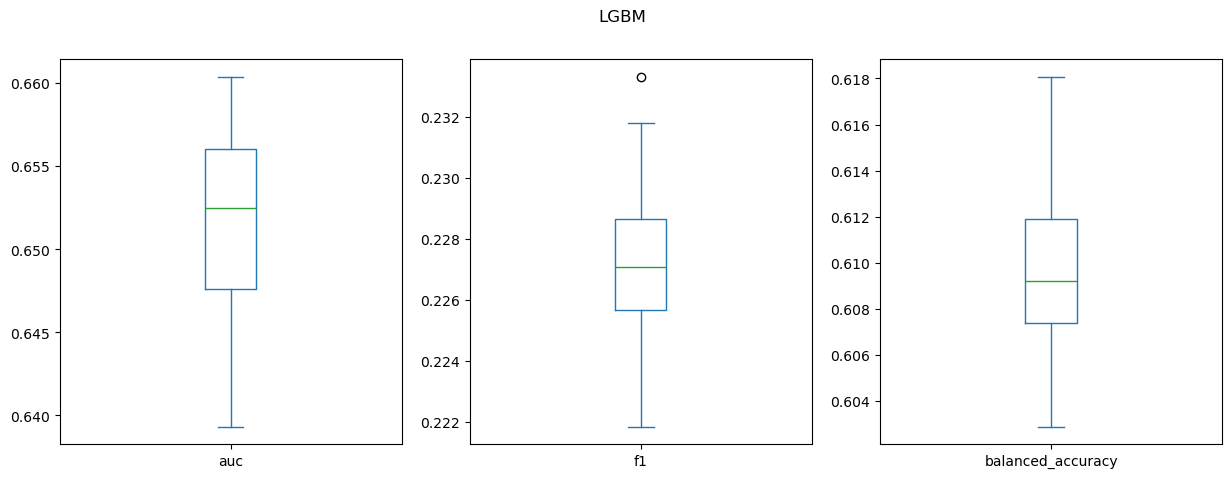

In [55]:
pd.DataFrame({"auc":test_score_auc,"f1":test_score_f1,"balanced_accuracy":test_score_bac}).plot(kind="box",subplots=True,layout=(1,3),figsize=(15,5),title="LGBM")

In [56]:
metrics.roc_auc_score(y_test_,pipe_prep_train.predict_proba(X_test_,)[:,1])

0.6524858099590022

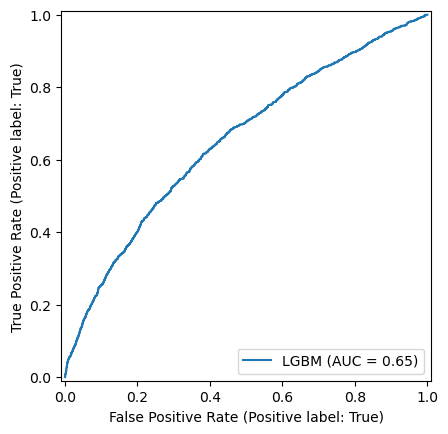

In [57]:
from sklearn import metrics
metrics.RocCurveDisplay.from_estimator(pipe_prep_train, X_test_, y_test_,name="LGBM")

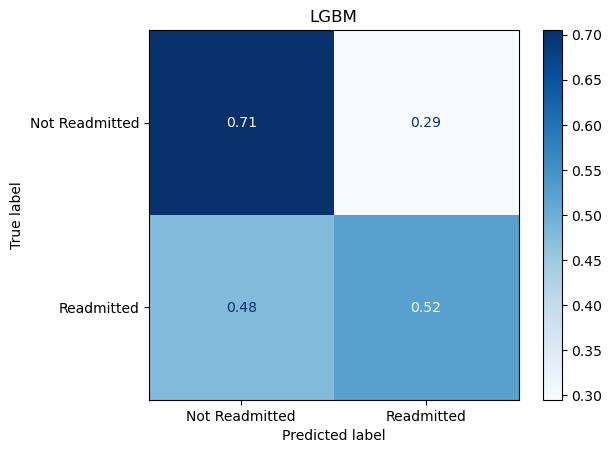

In [63]:
metrics.ConfusionMatrixDisplay.from_estimator(pipe_prep_train, X_test_, y_test_,normalize="true",cmap="Blues",display_labels=["Not Readmitted","Readmitted"],)
plt.title("LGBM")
plt.show()